In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from package import euklid_regressor as eu
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import optimizers
import tensorflow as tf

In [2]:
yahoo_df = pd.read_csv('../data/OIL.csv')

In [3]:
yahoo_df =yahoo_df[["Close",'SO',
                       'RSI_1', 'RSI_2', 'RSI_3', 'RSI_14', '1 Day ROI', '2 Day ROI',
                       '3 Day ROI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
                     "Previous_differenced",
                    "Differenced"]]
price = yahoo_df['Differenced'] 
close = yahoo_df['Close']
yahoo_df

,Close,SO,RSI_1,RSI_2,RSI_3,RSI_14,1 Day ROI,2 Day ROI,3 Day ROI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Previous_differenced,Differenced
0,28.709999,88.942238,88.167118,74.710855,67.792084,55.686023,0.005604,0.006662,0.017003,0.217881,0.047954,0.169927,0.001052,0.005604
1,28.980000,100.000000,94.912837,82.971376,74.729346,57.515026,0.009404,0.015061,0.016129,0.261059,0.072905,0.188153,0.005604,0.009404
2,28.860001,92.452898,62.992404,68.134442,66.270738,56.406417,-0.004141,0.005225,0.010858,0.282339,0.075349,0.206991,0.009404,-0.004141
3,28.910000,95.597504,71.093668,71.337782,68.266248,56.778336,0.001732,-0.002415,0.006966,0.299783,0.074234,0.225549,-0.004141,0.001732
4,29.910000,100.000000,97.037211,92.862721,87.689086,63.458814,0.034590,0.036383,0.032091,0.389806,0.131406,0.258401,0.001732,0.034590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236,112.120003,59.595269,92.289437,79.351172,70.956700,59.812992,0.070869,0.088755,0.179714,3.398582,-0.818534,4.217115,0.016702,0.070869
5237,111.760002,58.339161,86.713748,76.767088,69.383213,59.444077,-0.003211,0.067431,0.085259,3.690022,-0.421675,4.111697,0.070869,-0.003211
5238,114.930000,69.399868,93.562791,83.754692,75.707786,61.674259,0.028364,0.025062,0.097708,4.129184,0.013990,4.115194,-0.003211,0.028364
5239,112.339996,60.362867,50.784147,61.197273,61.800465,58.841720,-0.022535,0.005190,0.001962,4.219591,0.083517,4.136074,0.028364,-0.022535


In [4]:
# convert series to supervised learning
values = yahoo_df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
values

array([[ 2.8709999e+01,  8.8942238e+01,  8.8167114e+01, ...,
         1.6992721e-01,  1.0518506e-03,  5.6041977e-03],
       [ 2.8980000e+01,  1.0000000e+02,  9.4912834e+01, ...,
         1.8815349e-01,  5.6041977e-03,  9.4044050e-03],
       [ 2.8860001e+01,  9.2452896e+01,  6.2992405e+01, ...,
         2.0699069e-01,  9.4044050e-03, -4.1407500e-03],
       ...,
       [ 1.1493000e+02,  6.9399864e+01,  9.3562790e+01, ...,
         4.1151943e+00, -3.2108510e-03,  2.8364336e-02],
       [ 1.1234000e+02,  6.0362869e+01,  5.0784145e+01, ...,
         4.1360736e+00,  2.8364336e-02, -2.2535492e-02],
       [ 1.1390000e+02,  6.5806015e+01,  6.8263840e+01, ...,
         4.1822147e+00, -2.2535492e-02,  1.3886463e-02]], dtype=float32)

# Train, test, val

In [5]:
X =  yahoo_df[[  'SO',
                       'RSI_1', 'RSI_2', 'RSI_3', 'RSI_14', '1 Day ROI', '2 Day ROI',
                       '3 Day ROI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
                     "Previous_differenced",
                    ]]

y = yahoo_df["Differenced"]

In [6]:
# Split in 80/20 the dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,shuffle=False)
close_train, close_test = train_test_split(close,test_size = 0.20, shuffle=False)

close_train, close_test = list(close_train), list(close_test) 

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [8]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

y_train = y_train.values
y_test = y_test.values
print(X_train.shape)
print(y_train.shape)

(4192, 1, 12)
(4192,)


# LSTM

In [9]:
model = Sequential()
model.add(LSTM(75, return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(40))
model.add(Dense(1))

In [10]:
# Set early stopping monitor so the model stops training when it won't improve anymore
esm = EarlyStopping(monitor = 'loss', patience = 70)
# Set the optimizer
opt = tf.optimizers.SGD(learning_rate = 0.001)
#design network
batch_size = int(round(X_train.shape[0]*0.1))
# fit network
model.compile(loss='mae', optimizer=opt)
history = model.fit(X_train, y_train, epochs=2000, batch_size= batch_size, verbose=1,
    shuffle=False, validation_split=0.10)

Epoch 1/2000
10/10 [==============================] - 15s 443ms/step - loss: 0.3273 - val_loss: 0.1690
Epoch 2/2000
10/10 [==============================] - 2s 198ms/step - loss: 0.2214 - val_loss: 0.0966
Epoch 3/2000
10/10 [==============================] - 2s 270ms/step - loss: 0.1970 - val_loss: 0.0872
Epoch 4/2000
10/10 [==============================] - 2s 252ms/step - loss: 0.1936 - val_loss: 0.0869
Epoch 5/2000
10/10 [==============================] - 0s 49ms/step - loss: 0.1909 - val_loss: 0.0848
Epoch 6/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.1851 - val_loss: 0.0747
Epoch 7/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.1798 - val_loss: 0.0857
Epoch 8/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.1780 - val_loss: 0.0607
Epoch 9/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.1769 - val_loss: 0.0633
Epoch 10/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.1722 - v

10/10 [==============================] - 0s 21ms/step - loss: 0.0954 - val_loss: 0.0340
Epoch 82/2000
10/10 [==============================] - 0s 24ms/step - loss: 0.0930 - val_loss: 0.0294
Epoch 83/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0920 - val_loss: 0.0336
Epoch 84/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0909 - val_loss: 0.0251
Epoch 85/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0900 - val_loss: 0.0255
Epoch 86/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0889 - val_loss: 0.0306
Epoch 87/2000
10/10 [==============================] - 0s 24ms/step - loss: 0.0867 - val_loss: 0.0336
Epoch 88/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0898 - val_loss: 0.0366
Epoch 89/2000
10/10 [==============================] - 0s 26ms/step - loss: 0.0890 - val_loss: 0.0249
Epoch 90/2000
10/10 [==============================] - 0s 25ms/step - loss: 0.0860 - val_loss: 0

Epoch 161/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0348 - val_loss: 0.0144
Epoch 162/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0342 - val_loss: 0.0135
Epoch 163/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0327 - val_loss: 0.0135
Epoch 164/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0336 - val_loss: 0.0134
Epoch 165/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0327 - val_loss: 0.0133
Epoch 166/2000
10/10 [==============================] - 0s 23ms/step - loss: 0.0335 - val_loss: 0.0132
Epoch 167/2000
10/10 [==============================] - 0s 25ms/step - loss: 0.0324 - val_loss: 0.0133
Epoch 168/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0328 - val_loss: 0.0133
Epoch 169/2000
10/10 [==============================] - 0s 23ms/step - loss: 0.0324 - val_loss: 0.0130
Epoch 170/2000
10/10 [==============================] - 0s 23ms/step - lo

10/10 [==============================] - 1s 67ms/step - loss: 0.0226 - val_loss: 0.0114
Epoch 241/2000
10/10 [==============================] - 0s 40ms/step - loss: 0.0235 - val_loss: 0.0118
Epoch 242/2000
10/10 [==============================] - 1s 67ms/step - loss: 0.0232 - val_loss: 0.0117
Epoch 243/2000
10/10 [==============================] - 1s 75ms/step - loss: 0.0232 - val_loss: 0.0112
Epoch 244/2000
10/10 [==============================] - 1s 70ms/step - loss: 0.0236 - val_loss: 0.0114
Epoch 245/2000
10/10 [==============================] - 1s 58ms/step - loss: 0.0228 - val_loss: 0.0116
Epoch 246/2000
10/10 [==============================] - 1s 66ms/step - loss: 0.0232 - val_loss: 0.0112
Epoch 247/2000
10/10 [==============================] - 1s 62ms/step - loss: 0.0220 - val_loss: 0.0111
Epoch 248/2000
10/10 [==============================] - 1s 70ms/step - loss: 0.0221 - val_loss: 0.0114
Epoch 249/2000
10/10 [==============================] - 1s 52ms/step - loss: 0.0227 - va

10/10 [==============================] - 0s 19ms/step - loss: 0.0196 - val_loss: 0.0105
Epoch 320/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0192 - val_loss: 0.0108
Epoch 321/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0194 - val_loss: 0.0110
Epoch 322/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0199 - val_loss: 0.0106
Epoch 323/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0196 - val_loss: 0.0107
Epoch 324/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0194 - val_loss: 0.0105
Epoch 325/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0191 - val_loss: 0.0106
Epoch 326/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0196 - val_loss: 0.0107
Epoch 327/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0190 - val_loss: 0.0106
Epoch 328/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0194 - va

10/10 [==============================] - 0s 22ms/step - loss: 0.0173 - val_loss: 0.0103
Epoch 399/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0174 - val_loss: 0.0105
Epoch 400/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0175 - val_loss: 0.0103
Epoch 401/2000
10/10 [==============================] - 0s 25ms/step - loss: 0.0178 - val_loss: 0.0103
Epoch 402/2000
10/10 [==============================] - 0s 23ms/step - loss: 0.0173 - val_loss: 0.0104
Epoch 403/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0175 - val_loss: 0.0105
Epoch 404/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0177 - val_loss: 0.0102
Epoch 405/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0173 - val_loss: 0.0103
Epoch 406/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0180 - val_loss: 0.0103
Epoch 407/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0175 - va

10/10 [==============================] - 0s 17ms/step - loss: 0.0164 - val_loss: 0.0103
Epoch 478/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0166 - val_loss: 0.0105
Epoch 479/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0165 - val_loss: 0.0102
Epoch 480/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0164 - val_loss: 0.0101
Epoch 481/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0168 - val_loss: 0.0103
Epoch 482/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0163 - val_loss: 0.0100
Epoch 483/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0164 - val_loss: 0.0102
Epoch 484/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0163 - val_loss: 0.0101
Epoch 485/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0163 - val_loss: 0.0105
Epoch 486/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0169 - va

10/10 [==============================] - 0s 16ms/step - loss: 0.0157 - val_loss: 0.0100
Epoch 557/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0158 - val_loss: 0.0100
Epoch 558/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0156 - val_loss: 0.0101
Epoch 559/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0159 - val_loss: 0.0102
Epoch 560/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0157 - val_loss: 0.0100
Epoch 561/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0161 - val_loss: 0.0103
Epoch 562/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0158 - val_loss: 0.0100
Epoch 563/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0157 - val_loss: 0.0102
Epoch 564/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0159 - val_loss: 0.0102
Epoch 565/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0156 - va

10/10 [==============================] - 0s 22ms/step - loss: 0.0156 - val_loss: 0.0099
Epoch 636/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0153 - val_loss: 0.0100
Epoch 637/2000
10/10 [==============================] - 0s 23ms/step - loss: 0.0154 - val_loss: 0.0102
Epoch 638/2000
10/10 [==============================] - 0s 22ms/step - loss: 0.0154 - val_loss: 0.0100
Epoch 639/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0152 - val_loss: 0.0103
Epoch 640/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0153 - val_loss: 0.0100
Epoch 641/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0151 - val_loss: 0.0100
Epoch 642/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0153 - val_loss: 0.0101
Epoch 643/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0153 - val_loss: 0.0101
Epoch 644/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0154 - va

10/10 [==============================] - 0s 21ms/step - loss: 0.0148 - val_loss: 0.0099
Epoch 715/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0148 - val_loss: 0.0100
Epoch 716/2000
10/10 [==============================] - 0s 22ms/step - loss: 0.0151 - val_loss: 0.0101
Epoch 717/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0151 - val_loss: 0.0099
Epoch 718/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0147 - val_loss: 0.0101
Epoch 719/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0149 - val_loss: 0.0101
Epoch 720/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0150 - val_loss: 0.0103
Epoch 721/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0151 - val_loss: 0.0103
Epoch 722/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0150 - val_loss: 0.0100
Epoch 723/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0146 - va

10/10 [==============================] - 0s 23ms/step - loss: 0.0144 - val_loss: 0.0100
Epoch 794/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0147 - val_loss: 0.0102
Epoch 795/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0147 - val_loss: 0.0100
Epoch 796/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0145 - val_loss: 0.0099
Epoch 797/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0146 - val_loss: 0.0102
Epoch 798/2000
10/10 [==============================] - 0s 25ms/step - loss: 0.0148 - val_loss: 0.0100
Epoch 799/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0148 - val_loss: 0.0098
Epoch 800/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0144 - val_loss: 0.0100
Epoch 801/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0147 - val_loss: 0.0101
Epoch 802/2000
10/10 [==============================] - 0s 23ms/step - loss: 0.0147 - va

10/10 [==============================] - 1s 54ms/step - loss: 0.0144 - val_loss: 0.0101
Epoch 873/2000
10/10 [==============================] - 0s 48ms/step - loss: 0.0144 - val_loss: 0.0100
Epoch 874/2000
10/10 [==============================] - 0s 49ms/step - loss: 0.0146 - val_loss: 0.0100
Epoch 875/2000
10/10 [==============================] - 0s 37ms/step - loss: 0.0143 - val_loss: 0.0102
Epoch 876/2000
10/10 [==============================] - 1s 58ms/step - loss: 0.0141 - val_loss: 0.0103
Epoch 877/2000
10/10 [==============================] - 0s 52ms/step - loss: 0.0145 - val_loss: 0.0103
Epoch 878/2000
10/10 [==============================] - 0s 52ms/step - loss: 0.0146 - val_loss: 0.0099
Epoch 879/2000
10/10 [==============================] - 0s 39ms/step - loss: 0.0142 - val_loss: 0.0099
Epoch 880/2000
10/10 [==============================] - 1s 65ms/step - loss: 0.0145 - val_loss: 0.0099
Epoch 881/2000
10/10 [==============================] - 1s 53ms/step - loss: 0.0145 - va

10/10 [==============================] - 0s 12ms/step - loss: 0.0144 - val_loss: 0.0099
Epoch 952/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0140 - val_loss: 0.0099
Epoch 953/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0141 - val_loss: 0.0102
Epoch 954/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0141 - val_loss: 0.0101
Epoch 955/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0140 - val_loss: 0.0100
Epoch 956/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0142 - val_loss: 0.0100
Epoch 957/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0142 - val_loss: 0.0098
Epoch 958/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0138 - val_loss: 0.0100
Epoch 959/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0142 - val_loss: 0.0102
Epoch 960/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0145 - va

10/10 [==============================] - 0s 18ms/step - loss: 0.0141 - val_loss: 0.0099
Epoch 1031/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0139 - val_loss: 0.0098
Epoch 1032/2000
10/10 [==============================] - 0s 23ms/step - loss: 0.0139 - val_loss: 0.0100
Epoch 1033/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0140 - val_loss: 0.0099
Epoch 1034/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0138 - val_loss: 0.0099
Epoch 1035/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0138 - val_loss: 0.0102
Epoch 1036/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0141 - val_loss: 0.0102
Epoch 1037/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0142 - val_loss: 0.0103
Epoch 1038/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0142 - val_loss: 0.0098
Epoch 1039/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.

Epoch 1109/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0140 - val_loss: 0.0099
Epoch 1110/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0141 - val_loss: 0.0099
Epoch 1111/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0139 - val_loss: 0.0099
Epoch 1112/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0139 - val_loss: 0.0098
Epoch 1113/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0138 - val_loss: 0.0100
Epoch 1114/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0139 - val_loss: 0.0098
Epoch 1115/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0140 - val_loss: 0.0101
Epoch 1116/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0140 - val_loss: 0.0099
Epoch 1117/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0140 - val_loss: 0.0098
Epoch 1118/2000
10/10 [==============================] - 0s 17ms

Epoch 1188/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0136 - val_loss: 0.0098
Epoch 1189/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0136 - val_loss: 0.0098
Epoch 1190/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0137 - val_loss: 0.0099
Epoch 1191/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0139 - val_loss: 0.0098
Epoch 1192/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0137 - val_loss: 0.0097
Epoch 1193/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0139 - val_loss: 0.0100
Epoch 1194/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0139 - val_loss: 0.0098
Epoch 1195/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0135 - val_loss: 0.0098
Epoch 1196/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0137 - val_loss: 0.0099
Epoch 1197/2000
10/10 [==============================] - 0s 17ms

Epoch 1267/2000
10/10 [==============================] - 0s 23ms/step - loss: 0.0137 - val_loss: 0.0098
Epoch 1268/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0137 - val_loss: 0.0099
Epoch 1269/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0138 - val_loss: 0.0097
Epoch 1270/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0136 - val_loss: 0.0099
Epoch 1271/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0139 - val_loss: 0.0097
Epoch 1272/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0134 - val_loss: 0.0097
Epoch 1273/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0135 - val_loss: 0.0100
Epoch 1274/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0137 - val_loss: 0.0099
Epoch 1275/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0136 - val_loss: 0.0097
Epoch 1276/2000
10/10 [==============================] - 0s 21ms

Epoch 1346/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0138 - val_loss: 0.0098
Epoch 1347/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0137 - val_loss: 0.0097
Epoch 1348/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0138 - val_loss: 0.0097
Epoch 1349/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0134 - val_loss: 0.0099
Epoch 1350/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0135 - val_loss: 0.0097
Epoch 1351/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0135 - val_loss: 0.0098
Epoch 1352/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0136 - val_loss: 0.0099
Epoch 1353/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0137 - val_loss: 0.0096
Epoch 1354/2000
10/10 [==============================] - 0s 22ms/step - loss: 0.0134 - val_loss: 0.0099
Epoch 1355/2000
10/10 [==============================] - 0s 19ms

Epoch 1425/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0138 - val_loss: 0.0099
Epoch 1426/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0135 - val_loss: 0.0097
Epoch 1427/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0135 - val_loss: 0.0097
Epoch 1428/2000
10/10 [==============================] - 0s 23ms/step - loss: 0.0135 - val_loss: 0.0099
Epoch 1429/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0136 - val_loss: 0.0100
Epoch 1430/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0138 - val_loss: 0.0098
Epoch 1431/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0135 - val_loss: 0.0097
Epoch 1432/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0137 - val_loss: 0.0098
Epoch 1433/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0136 - val_loss: 0.0099
Epoch 1434/2000
10/10 [==============================] - 0s 11ms

Epoch 1504/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0136 - val_loss: 0.0099
Epoch 1505/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0136 - val_loss: 0.0095
Epoch 1506/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0133 - val_loss: 0.0098
Epoch 1507/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0136 - val_loss: 0.0097
Epoch 1508/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0136 - val_loss: 0.0097
Epoch 1509/2000
10/10 [==============================] - 0s 22ms/step - loss: 0.0134 - val_loss: 0.0097
Epoch 1510/2000
10/10 [==============================] - 0s 24ms/step - loss: 0.0133 - val_loss: 0.0097
Epoch 1511/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0133 - val_loss: 0.0098
Epoch 1512/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0135 - val_loss: 0.0099
Epoch 1513/2000
10/10 [==============================] - 0s 21ms

Epoch 1583/2000
10/10 [==============================] - 0s 53ms/step - loss: 0.0135 - val_loss: 0.0095
Epoch 1584/2000
10/10 [==============================] - 1s 54ms/step - loss: 0.0133 - val_loss: 0.0097
Epoch 1585/2000
10/10 [==============================] - 0s 52ms/step - loss: 0.0133 - val_loss: 0.0100
Epoch 1586/2000
10/10 [==============================] - 0s 32ms/step - loss: 0.0135 - val_loss: 0.0096
Epoch 1587/2000
10/10 [==============================] - 0s 46ms/step - loss: 0.0134 - val_loss: 0.0097
Epoch 1588/2000
10/10 [==============================] - 0s 53ms/step - loss: 0.0134 - val_loss: 0.0097
Epoch 1589/2000
10/10 [==============================] - 0s 50ms/step - loss: 0.0133 - val_loss: 0.0096
Epoch 1590/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.0134 - val_loss: 0.0098
Epoch 1591/2000
10/10 [==============================] - 0s 45ms/step - loss: 0.0134 - val_loss: 0.0096
Epoch 1592/2000
10/10 [==============================] - 1s 66ms

Epoch 1662/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0134 - val_loss: 0.0096
Epoch 1663/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0134 - val_loss: 0.0095
Epoch 1664/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0135 - val_loss: 0.0096
Epoch 1665/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0134 - val_loss: 0.0097
Epoch 1666/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0134 - val_loss: 0.0097
Epoch 1667/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0133 - val_loss: 0.0099
Epoch 1668/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0136 - val_loss: 0.0095
Epoch 1669/2000
10/10 [==============================] - 0s 23ms/step - loss: 0.0133 - val_loss: 0.0098
Epoch 1670/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0134 - val_loss: 0.0096
Epoch 1671/2000
10/10 [==============================] - 0s 19ms

Epoch 1741/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0134 - val_loss: 0.0096
Epoch 1742/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0133 - val_loss: 0.0096
Epoch 1743/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0132 - val_loss: 0.0097
Epoch 1744/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0132 - val_loss: 0.0096
Epoch 1745/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0131 - val_loss: 0.0096
Epoch 1746/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0132 - val_loss: 0.0096
Epoch 1747/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0133 - val_loss: 0.0097
Epoch 1748/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0133 - val_loss: 0.0096
Epoch 1749/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0135 - val_loss: 0.0097
Epoch 1750/2000
10/10 [==============================] - 0s 23ms

Epoch 1820/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0132 - val_loss: 0.0097
Epoch 1821/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0133 - val_loss: 0.0098
Epoch 1822/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0132 - val_loss: 0.0095
Epoch 1823/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0133 - val_loss: 0.0097
Epoch 1824/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0132 - val_loss: 0.0096
Epoch 1825/2000
10/10 [==============================] - 0s 22ms/step - loss: 0.0132 - val_loss: 0.0095
Epoch 1826/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0132 - val_loss: 0.0098
Epoch 1827/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0135 - val_loss: 0.0095
Epoch 1828/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0132 - val_loss: 0.0098
Epoch 1829/2000
10/10 [==============================] - 0s 19ms

Epoch 1899/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0133 - val_loss: 0.0096
Epoch 1900/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0132 - val_loss: 0.0095
Epoch 1901/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0132 - val_loss: 0.0095
Epoch 1902/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0132 - val_loss: 0.0096
Epoch 1903/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0133 - val_loss: 0.0095
Epoch 1904/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0131 - val_loss: 0.0097
Epoch 1905/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0133 - val_loss: 0.0096
Epoch 1906/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0131 - val_loss: 0.0096
Epoch 1907/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0133 - val_loss: 0.0096
Epoch 1908/2000
10/10 [==============================] - 0s 14ms

Epoch 1978/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0133 - val_loss: 0.0095
Epoch 1979/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0132 - val_loss: 0.0096
Epoch 1980/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0132 - val_loss: 0.0095
Epoch 1981/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0131 - val_loss: 0.0097
Epoch 1982/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0132 - val_loss: 0.0095
Epoch 1983/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0134 - val_loss: 0.0096
Epoch 1984/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0132 - val_loss: 0.0095
Epoch 1985/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0132 - val_loss: 0.0096
Epoch 1986/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0131 - val_loss: 0.0096
Epoch 1987/2000
10/10 [==============================] - 0s 17ms

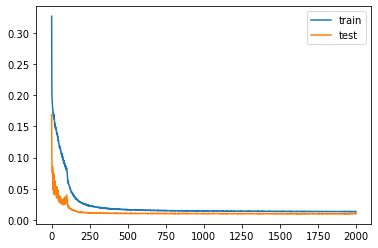

In [11]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Prediction 

In [12]:
predict = model.predict(X_test)
predict = [float(predict[i]) for i in range(len(predict))]
pred = eu.scale_back_pct(predict, close_test)
updown_pred = eu.ud_pred(pred, close_test)

In [13]:
df = pd.DataFrame(updown_pred)
df["Close"] = list(close_test)
df["updown_pred"] = df.iloc[:,0]
df["updown_actual"] = eu.ud(close_test)
df["Scaled_pred"] = pred
df["Pred"] = predict
df = df.iloc[:,1:] 
acc = (df["updown_pred"] == df["updown_actual"]).sum()/df.shape[0]
print('Model Accuracy: ', acc)


Model Accuracy:  0.8303145853193518


In [14]:
df

,Close,updown_pred,updown_actual,Scaled_pred,Pred
0,65.559998,1,1,65.559998,-0.000878
1,64.500000,0,0,64.906786,-0.009964
2,64.730003,0,1,64.089072,-0.006371
3,65.800003,1,1,65.666593,0.014469
4,65.449997,1,0,66.100810,0.004572
...,...,...,...,...,...
1044,112.120003,1,1,106.532748,0.017505
1045,111.760002,1,0,114.013697,0.016890
1046,114.930000,1,1,113.712201,0.017468
1047,112.339996,1,0,115.183829,0.002209


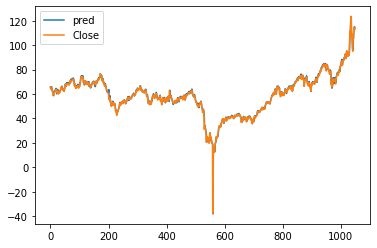

In [15]:
plt.plot(df['Scaled_pred'], label='pred')
plt.plot(df["Close"], label='Close')
plt.legend()
plt.show()

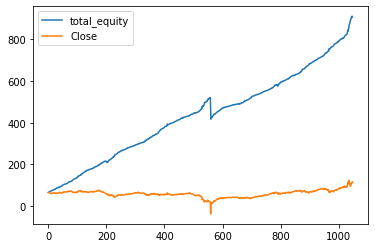

In [16]:
df_equity = pd.DataFrame()
df_equity["long_equity"] = eu.long_equity(df["updown_pred"], df["Close"])
df_equity["short_equity"] = eu.short_equity(df["updown_pred"], df["Close"])
df_equity["total_equity"] = eu.total_equity(df["updown_pred"], df["Close"])
df_equity["total_equity"].cumsum().plot()
df["Close"].plot()
plt.legend()

# Save Accuracies

In [17]:
df_prediction = pd.read_csv("../data/model_accuracy_oil.csv", index_col = False)
df_prediction

,Unnamed: 0,ANN_pred,ANN_accuracy,ANN_prob,y,kNN_pred,kNN_accuracy,kNN_prob,RF_pred,RF_accuracy,RF_prob,XGB_pred,XGB_accuracy,XGB_prob,LGBM_pred,LGBM_accuracy,LGBM_prob,SVC_pred,SVC_accuracy,SVC_prob
0,0,0,0.469018,0.404047,0,1,0.488084,1.0,0,0.514776,0.440374,0,0.521449,0.499819,1,0.533842,0.513085,1,0.522402,0.529821
1,1,0,0.469018,0.342436,1,0,0.488084,0.0,1,0.514776,0.558104,1,0.521449,0.511250,1,0.533842,0.513026,1,0.522402,0.509924
2,2,0,0.469018,0.339922,1,0,0.488084,0.0,1,0.514776,0.565385,0,0.521449,0.494657,1,0.533842,0.513026,0,0.522402,0.491893
3,3,0,0.469018,0.404326,0,1,0.488084,1.0,1,0.514776,0.522251,1,0.521449,0.500281,1,0.533842,0.504916,0,0.522402,0.500000
4,4,0,0.469018,0.361674,0,1,0.488084,1.0,1,0.514776,0.583792,1,0.521449,0.529373,1,0.533842,0.515756,1,0.522402,0.515805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,1044,0,0.469018,0.448136,0,0,0.488084,0.5,0,0.514776,0.470678,1,0.521449,0.549180,1,0.533842,0.506586,1,0.522402,0.532198
1045,1045,0,0.469018,0.448477,1,0,0.488084,0.5,0,0.514776,0.485184,1,0.521449,0.531798,1,0.533842,0.505718,1,0.522402,0.546324
1046,1046,0,0.469018,0.438599,0,0,0.488084,0.5,0,0.514776,0.466790,1,0.521449,0.512161,1,0.533842,0.506459,1,0.522402,0.518366
1047,1047,0,0.469018,0.417918,1,0,0.488084,0.0,1,0.514776,0.589712,1,0.521449,0.542420,1,0.533842,0.508596,1,0.522402,0.554229


In [18]:
df_prediction["LSTM_price_accuracy"] = [acc for x in range(len(df_prediction))]


In [19]:
df_prediction.to_csv("../data/model_accuracy_oil.csv")